### Cross approach
- CAM attention for shadow removal networks only
- Integrating CAMs into shadow generator
- CAM coeff = 500. It was a better variant for ugatit option. Should be further tuned.

Current version:
  - Integrating CAM inside B2A
  - Using learned weights in A2B to rebalance channels in B2A.

In [1]:
from google.colab import drive
import os
drive.mount('/content/drive/')
path_basic = 'drive/My Drive/gan_experiments'
os.chdir(path_basic)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
import torch
from torch.nn import init
from torch import nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
from torch.autograd import Variable
from torch.utils.tensorboard import SummaryWriter 

from skimage.filters import threshold_otsu
from PIL import Image
import cv2
import functools
import itertools
import numpy as np
import random

import h5py

import os
import sys
import glob
from tqdm import tqdm_notebook
import re

import matplotlib.pyplot as plt
import pickle
import time

### Additional modules implementation

In [0]:
# timer utils
import time
import functools
def timer(f):
  @functools.wraps(f)
  def wrapper(*args, **kwargs):
    start_time = time.time()
    r = f(*args, **kwargs)
    duration = time.time() - start_time
    result = {
        'result':r,
        'time':duration
    }
    return result
  return wrapper

In [0]:
class CAMAttention(nn.Module):
  def __init__(self, input_nc):
    super(CAMAttention, self).__init__()
    self.gap_fc = nn.utils.spectral_norm(nn.Linear(input_nc, 1, bias=False))
    self.gmp_fc = nn.utils.spectral_norm(nn.Linear(input_nc, 1, bias=False))

    self.conv_1x1 = nn.utils.spectral_norm(nn.Conv2d(input_nc * 2, input_nc, 1))
    self.relu = nn.ReLU(True)


  def forward(self, x):
    # global avg. pool.
    gap = F.adaptive_avg_pool2d(x, 1)
    gap = gap.view(gap.shape[0], -1)
    gap_fc = self.gap_fc(gap)
    gap_weights = next(self.gap_fc.parameters()).unsqueeze(2).unsqueeze(3)
    gap_output = x * gap_weights

    # global max. pool.
    gmp = F.adaptive_max_pool2d(x, 1)
    gmp = gmp.view(gmp.shape[0], -1)
    gmp_fc = self.gmp_fc(gmp)
    gmp_weights = next(self.gmp_fc.parameters()).unsqueeze(2).unsqueeze(3)
    gmp_output = x * gmp_weights

    cam_loss = torch.cat([gap_fc, gmp_fc], axis=1)
    gap_gmp_output = torch.cat([gap_output, gmp_output], axis=1)

    
    output = self.relu(self.conv_1x1(gap_gmp_output))
    attention = torch.sum(output, axis=1, keepdims=True)

    return output, attention, cam_loss, gap_weights, gmp_weights

In [0]:
test = torch.rand(1,3,32,32)
model = CAMAttention(3)
out = model(test)

### Blocks

In [0]:
class ResidualBlock(nn.Module):
    """
      Parameters:
        dilation_factor -- dilated convolution hyperparam
    """
    def __init__(self, in_features, dilation_factor, r=4):
        super(ResidualBlock, self).__init__()
        k = 3
        d = dilation_factor
        pad = int(((k - 1) * (d - 1) + k - 1) / 2)

        conv_block = [  nn.ReflectionPad2d(pad),
                        nn.utils.spectral_norm(nn.Conv2d(in_features, in_features, 3, dilation=d)),
                        nn.InstanceNorm2d(in_features),
                        nn.ReLU(inplace=True),
                      
                        nn.ReflectionPad2d(pad),
                        nn.utils.spectral_norm(nn.Conv2d(in_features, in_features, 3, dilation=d)),
                        nn.InstanceNorm2d(in_features)
                      ]

        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return x + self.conv_block(x)


class Generator_S2F(nn.Module):
    """
      attn_idx -- index of the bottleneck block onwards to place attention block
    """
    def __init__(self, input_nc, output_nc, n_residual_blocks=9,
                 dilation_factors=[1,1,1,2,4,8,16,1,1],
                 attn_idx=4):
        super(Generator_S2F, self).__init__()
        assert len(dilation_factors) == n_residual_blocks

        downsample = []
        bottleneck_1 = []  # modules before attention
        bottleneck_2 = []  # modules after attention
        upsample = []

        # Initial convolution block
        downsample += [   nn.ReflectionPad2d(3),
                    nn.utils.spectral_norm(nn.Conv2d(input_nc, 64, 7)),
                    nn.InstanceNorm2d(64),
                    nn.ReLU(inplace=True) ]

        # Downsampling
        in_features = 64
        out_features = in_features*2
        for _ in range(2):
            downsample += [  nn.utils.spectral_norm(nn.Conv2d(in_features, out_features, 3, stride=2, padding=1)),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features*2

        # Residual blocks
        # Paste attn module before dilation growth
        for i in range(attn_idx):
          d = dilation_factors[i]
          bottleneck_1 += [ResidualBlock(in_features,dilation_factor=d)]

        self.cam_attn = CAMAttention(in_features)
        for i in range(attn_idx, n_residual_blocks):
          d = dilation_factors[i]
          bottleneck_2 += [ResidualBlock(in_features,dilation_factor=d)]

        # Upsampling
        out_features = in_features//2
        for _ in range(2):
            upsample += [  nn.utils.spectral_norm(nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1)),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features//2

        # Output layer
        upsample += [  nn.ReflectionPad2d(3),
                    nn.utils.spectral_norm(nn.Conv2d(64, output_nc, 7)) ]
                    #nn.Tanh() ]

        self.downsample = nn.Sequential(*downsample)
        self.bottleneck_1 = nn.Sequential(*bottleneck_1)
        self.bottleneck_2 = nn.Sequential(*bottleneck_2)
        self.upsample = nn.Sequential(*upsample)

    def forward(self, x):
      downsampled = self.downsample(x)

      bottleneck_1 = self.bottleneck_1(downsampled)
      cam_output, cam_attn, cam_loss, cam_gap_weights, cam_gmp_weights = self.cam_attn(bottleneck_1)
      bottleneck_2 = self.bottleneck_2(cam_output)

      output = self.upsample(bottleneck_2)
      output = (output + x).tanh() #(min=-1, max=1) #just learn a residual
      return output, cam_attn, cam_loss, cam_gap_weights, cam_gmp_weights


class Generator_F2S(nn.Module):
    def __init__(self, input_nc, output_nc, n_residual_blocks=9,
                 dilation_factors=[1,1,1,2,4,8,16,1,1],
                 attn_idx=-1):
        super(Generator_F2S, self).__init__()
        assert len(dilation_factors) == n_residual_blocks
        self.attn_idx = attn_idx
        downsample = []
        if self.attn_idx > 0:
          bottleneck_1 = []  # modules before attention
          bottleneck_2 = []  # modules after attention
        else:
          bottleneck = []

        upsample = []

        # Initial convolution block
        downsample += [   nn.ReflectionPad2d(3),
                    nn.utils.spectral_norm(nn.Conv2d(input_nc+1, 64, 7)), # + mask
                    nn.InstanceNorm2d(64),
                    nn.ReLU(inplace=True) ]

        # Downsampling
        in_features = 64
        out_features = in_features*2
        for _ in range(2):
            downsample += [  nn.utils.spectral_norm(nn.Conv2d(in_features, out_features, 3, stride=2, padding=1)),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features*2

        # Residual blocks
        # Paste attn module before dilation growth
        for i in range(attn_idx):
          d = dilation_factors[i]
          bottleneck_1 += [ResidualBlock(in_features,dilation_factor=d)]

        self.conv_1x1 = nn.utils.spectral_norm(nn.Conv2d(in_features * 2, in_features, 1))
        self.relu = nn.ReLU(True)

        for i in range(attn_idx, n_residual_blocks):
          d = dilation_factors[i]
          bottleneck_2 += [ResidualBlock(in_features,dilation_factor=d)]

        # Upsampling
        out_features = in_features//2
        for _ in range(2):
            upsample += [  nn.utils.spectral_norm(nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1)),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features//2

        # Output layer
        upsample += [  nn.ReflectionPad2d(3),
                    nn.utils.spectral_norm(nn.Conv2d(64, output_nc, 7)) ]
                    #nn.Tanh() ]

        self.downsample = nn.Sequential(*downsample)

        self.bottleneck_1 = nn.Sequential(*bottleneck_1)
        self.bottleneck_2 = nn.Sequential(*bottleneck_2)

        self.upsample = nn.Sequential(*upsample)

        model = downsample + bottleneck_1 + bottleneck_2 + upsample
        self.model = nn.Sequential(*model)


    def forward(self, x, mask, weights):
      if weights[0] is None:
        # if identity
        return (self.model(torch.cat((x, mask), axis=1)) + x).tanh()

      downsampled = self.downsample(torch.cat((x, mask), 1))

      bottleneck_1_output = self.bottleneck_1(downsampled)
      # cam attention integrating. rebalancing.      
      gap_weights, gmp_weights = weights
      gap_output = bottleneck_1_output * gap_weights
      gmp_output = bottleneck_1_output * gmp_weights
      gap_gmp_output = torch.cat([gap_output, gmp_output], axis=1)
      cam_output = self.relu(self.conv_1x1(gap_gmp_output))  # return initial number of channels
      cam_attn = torch.sum(cam_output, axis=1, keepdims=True)  # for qualitative estimation

      bottleneck_2_output = self.bottleneck_2(cam_output)
      output = self.upsample(bottleneck_2_output)
      output = (output + x).tanh()  # (min=-1, max=1) #just learn a residual
      return output, cam_attn


class Discriminator(nn.Module):
    def __init__(self, input_nc, attn=True):
        super(Discriminator, self).__init__()

        # A bunch of convolutions one after another
        self.attn = attn
        model = []

        model += [nn.utils.spectral_norm(nn.Conv2d(input_nc, 64, 4, stride=2, padding=1)),
                 nn.LeakyReLU(0.2, inplace=True) ]

        model += [nn.utils.spectral_norm(nn.Conv2d(64, 128, 4, stride=2, padding=1)),
                  nn.InstanceNorm2d(128),
                  nn.LeakyReLU(0.2, inplace=True) ]

        model += [nn.utils.spectral_norm(nn.Conv2d(128, 256, 4, stride=2, padding=1)),
                  nn.InstanceNorm2d(256),
                  nn.LeakyReLU(0.2, inplace=True) ]

        model += [nn.utils.spectral_norm(nn.Conv2d(256, 512, 4, padding=1)),
                  nn.InstanceNorm2d(512),
                  nn.LeakyReLU(0.2, inplace=True) ]

        # CAM layers
        if self.attn:
          self.cam_attn = CAMAttention(512)
          self.conv_output = nn.utils.spectral_norm(nn.Conv2d(512, 1, 4, padding=1))
        else:
          model += [nn.utils.spectral_norm(nn.Conv2d(512, 1, 4, padding=1))]

        self.model = nn.Sequential(*model)


    def forward(self, x):
      x = self.model(x)
      if not self.attn:
        # Average pooling and flatten
        return F.avg_pool2d(x, x.size()[2:]).view(x.size()[0], -1) #global avg pool

      cam_output, cam_attn, cam_loss,_,_ = self.cam_attn(x)
      output = self.conv_output(cam_output)
      output = F.avg_pool2d(output, output.size()[2:]).view(output.size()[0], -1) #global avg pool
      return output, cam_attn, cam_loss

In [0]:
test = torch.rand(1,3,256,256)
gab = Generator_S2F(3,3,attn_idx=4)
gba_attn = Generator_S2F(3,3,attn_idx=4)
gba_noattn = Generator_S2F(3,3,attn_idx=-1)
d_attn = Discriminator(3, attn=True)
d_noattn = Discriminator(3, attn=False)

In [0]:
gab_out, gab_attn, gab_cam = gab(test)
gba_attn_out, gba_attn_attn, gba_attn_cam = gba_attn(test)
gba_noattn_out = gba_noattn(test)

d_attn_out, d_attn_attn, d_attn_cam = d_attn(test)
d_noattn_out = d_noattn(test)

In [0]:
gab_attn

tensor([[[[7.1170, 6.2092, 6.4364,  ..., 5.8054, 6.1612, 5.3988],
          [6.5128, 6.3957, 5.9861,  ..., 6.6703, 7.8026, 6.6175],
          [5.8081, 5.6422, 7.0622,  ..., 5.9779, 6.3982, 6.6766],
          ...,
          [5.1379, 6.5081, 5.8854,  ..., 6.8845, 6.2883, 6.3895],
          [6.9261, 6.6220, 6.6822,  ..., 7.7174, 4.6873, 8.0985],
          [5.0194, 6.5406, 6.7473,  ..., 6.2798, 6.0392, 5.7299]]]],
       grad_fn=<SumBackward1>)

In [0]:
d_noattn_out

tensor([[-0.2523]], grad_fn=<ViewBackward>)

In [0]:
gab = Generator_S2F(3,3,attn_idx=4)
gab.to(device)
_=gab.apply(weights_init_normal)

In [0]:
tr = [
      transforms.Resize((image_size, image_size), interpolation=Image.BICUBIC),
      transforms.ToTensor(),
      transforms.Normalize((.5,.5,.5),(.5,.5,.5))
]
dt = ImageDatasetValidation(root_dir, transforms_=tr, mode='val')
img = dt[0]['A']

In [0]:
img = img.to(device).unsqueeze(0)

In [0]:
_, attn, _ = gab(img)
attn.max(), attn.min()

In [0]:
attn_norm = (attn - attn.min()) / (attn.max() - attn.min())
print(attn_norm.max(), attn_norm.min())

tensor(1., device='cuda:0', grad_fn=<MaxBackward1>) tensor(0., device='cuda:0', grad_fn=<MinBackward1>)


In [0]:
attn_norm = (attn_norm - 0.5) / 0.5
print(attn_norm.max(), attn_norm.min())

tensor(1., device='cuda:0', grad_fn=<MaxBackward1>) tensor(-1., device='cuda:0', grad_fn=<MinBackward1>)


In [0]:
attn_array = attn.data.squeeze(0).squeeze(0).cpu().numpy()
attn_norm_array = attn_norm.data.squeeze(0).squeeze(0).cpu().numpy()

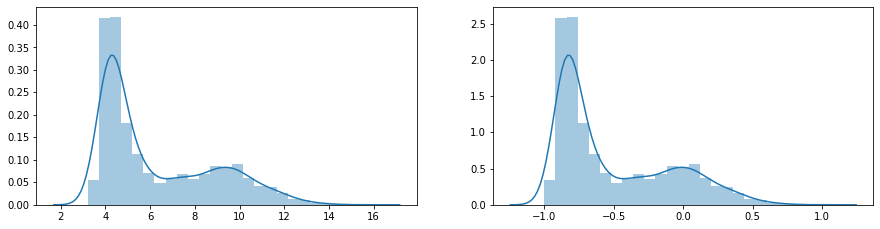

In [0]:
import seaborn as sns
plt.subplots(figsize=(15,8))
plt.subplot(2,2,1)
sns.distplot(attn_array.flatten())

plt.subplot(2,2,2)
sns.distplot(attn_norm_array.flatten())

In [0]:
def cam(x, size = 256):
    x = x - np.min(x)
    cam_img = x / np.max(x)
    cam_img = np.uint8(255 * cam_img)
    cam_img = cv2.resize(cam_img, (size, size))
    cam_img = cv2.applyColorMap(cam_img, cv2.COLORMAP_JET)
    return cam_img / 255.0

In [0]:
gab_attn = cam(gab_attn.detach().numpy().squeeze())

In [0]:
plt.imshow(gab_attn)

### Buffers

In [0]:
class ReplayBuffer():
    def __init__(self, max_size=50):
        assert (max_size > 0), 'Empty buffer or trying to create a black hole. Be careful.'
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0,1) > 0.5:
                    i = random.randint(0, self.max_size-1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return Variable(torch.cat(to_return))

class QueueMask():
    def __init__(self, length):
        self.max_length = length
        self.queue = []

    def insert(self, mask, weights):
        if self.queue.__len__() >= self.max_length:
            self.queue.pop(0)
        self.queue.append((mask, weights))

    def preprocess(self, mask, attn):
      # attention resizing
      attn = self.prepare_attn(attn)
      output = torch.cat([mask, attn], axis=1)
      return output

    def prepare_attn(self, attn):
      # resize the image to (image_size, image_size)
      attn = attn.data.squeeze().cpu().numpy()
      attn = cv2.resize(attn, (image_size, image_size),interpolation=cv2.INTER_CUBIC)
      attn = torch.cuda.FloatTensor(attn).unsqueeze(0).unsqueeze(0)

      # normalize values to [-1,1]
      attn = (attn - attn.min()) / (attn.max() - attn.min())
      attn = (attn - 0.5) / 0.5
      return attn

    def rand_item(self):
        assert self.queue.__len__() > 0, 'Error! Empty queue!'
        return self.queue[np.random.randint(0, self.queue.__len__())]

    def last_item(self):
        assert self.queue.__len__() > 0, 'Error! Empty queue!'
        return self.queue[self.queue.__len__()-1]
        

class ImageDatasetHDF5(Dataset):
    def __init__(self, path_hdf5, transforms_=None):
        self.transform = transforms.Compose(transforms_)
        self.files = h5py.File(path_hdf5, "r")
        self.domain_A = 'domain_A'
        self.domain_B = 'domain_B'

        self.length_A = self.files[self.domain_A].shape[0]
        self.length_B = self.files[self.domain_B].shape[0]

    @timer
    def __getitem__(self, index):
        item_A = self.transform(self.files[self.domain_A][index % self.length_A])
        item_B = self.transform(self.files[self.domain_B][random.randint(0, self.length_B - 1)])
        return {'A': item_A, 'B': item_B}

    def __len__(self):
        return max(self.length_A, self.length_B)


class ImageDatasetValidation(Dataset):
    def __init__(self, root, paired=False, transforms_=None, mode='val', mask=False):
        self.transform = transforms.Compose(transforms_)
        self.paired = paired
        self.files_A = sorted(glob.glob(os.path.join(root, f'{mode}/{mode}_A', '*.png')))
        self.files_B = sorted(glob.glob(os.path.join(root, f'{mode}/{mode}_C', '*.png')))
        self.mask = mask
        if self.mask:
          self.transform_mask = transforms.Compose([transforms.Resize((image_size, image_size), interpolation=Image.BICUBIC),
                                                    transforms.ToTensor()])
          self.files_mask = sorted(glob.glob(os.path.join(root, f'{mode}/{mode}_B', '*.png')))

    def __getitem__(self, index):
        item_A = self.transform(Image.open(self.files_A[index % len(self.files_A)]))
        
        if self.paired:
          item_B = self.transform(Image.open(self.files_B[index % len(self.files_B)]))
          if self.mask:
            item_mask = self.transform_mask(Image.open(self.files_mask[index % len(self.files_mask)]))
            return {'A': item_A, 'B': item_B, 'mask':item_mask}  
          return {'A': item_A, 'B': item_B}  
        item_B = self.transform(Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)]))
        return {'A': item_A, 'B': item_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

In [0]:
# V0.1.0 num params
V010_G = 45.512
V010_D = 11.058
V010_S = 56.57

In [0]:
# summary of the models
def num_params(model):
  model_parameters = filter(lambda p: p.requires_grad, model.parameters())
  params = sum([np.prod(p.size()) for p in model_parameters])
  return params

dL = Discriminator(3, attn=True)
g = Generator_S2F(3,3)

V011_D = round(num_params(dL) * 2 / 1e6, 3) * 2
V011_G = round(num_params(g) * 2 / 1e6, 3) * 2
V011_S = round(V011_D + V011_G, 3)

print('---- Summary models ----')
print("Number of parameters (in millions):")
print("{:10}{:10}{:20}".format("D", 'G', "Overall"))
print("{:10}{:10}{:20}".format(str(V011_D), str(V011_G), str(V011_S)))

print(f"GAIN PARAMS: {round((V011_S / V010_S - 1) * 100, 3)}%")

---- Summary models ----
Number of parameters (in millions):
D         G         Overall             
13.162    46.04     59.202              
GAIN PARAMS: 4.653%


### Utils

In [0]:
to_pil = transforms.ToPILImage()
to_gray = transforms.Grayscale(num_output_channels=1)


def mask_generator(shadow, shadow_free):
	im_f = to_gray(to_pil(((shadow_free.data.squeeze(0) + 1.0) * 0.5).cpu()))
	im_s = to_gray(to_pil(((shadow.data.squeeze(0) + 1.0) * 0.5).cpu()))

	diff = (np.asarray(im_f, dtype='float32')- np.asarray(im_s, dtype='float32')) # difference between shadow image and shadow_free image
	L = threshold_otsu(diff)
	mask = torch.tensor((np.float32(diff >= L)-0.5)/0.5).unsqueeze(0).unsqueeze(0).cuda() #-1.0:non-shadow, 1.0:shadow
	mask.requires_grad = False
	return mask



def tensor2image(tensor):
    image = 127.5*(tensor[0].cpu().float().numpy() + 1.0)
    if image.shape[0] == 1:
        image = np.tile(image, (3,1,1))
    return image.astype(np.uint8)

def cam(x, size = 256):
    x = x - np.min(x)
    cam_img = x / np.max(x)
    cam_img = np.uint8(255 * cam_img)
    cam_img = cv2.resize(cam_img, (size, size))
    cam_img = cv2.applyColorMap(cam_img, cv2.COLORMAP_JET)
    return cam_img


class LambdaLR():
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert ((n_epochs - decay_start_epoch) > 0), "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch)/(self.n_epochs - self.decay_start_epoch)

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

### Evaluators

In [0]:
def read_paths(path):
  with open(path, 'rb') as f:
    paths = pickle.load(f)
  return paths

def mkdir(path):
  try:
    os.mkdir(path)
  except FileExistsError as e:
    pass

def save_test(A_path, B_path, save_path):
  start_time = time.time()
  A_paths = read_paths(A_path)
  B_paths = read_paths(B_path)
  
  assert len(A_paths) == len(B_paths)
  # read and preprocess the test images
  os.makedirs(save_path, exist_ok=True)

  mkdir(os.path.join(save_path, 'A_B'))
  mkdir(os.path.join(save_path, 'B_A'))

  mkdir(os.path.join(save_path, 'masks'))
  mkdir(os.path.join(save_path, 'attn_A_B'))
  mkdir(os.path.join(save_path, 'attn_B_A'))

  # load the model
  netG_A2B = Generator_S2F(input_nc, output_nc, attn_idx=attn_idx_GAB).to(device)
  netG_B2A = Generator_F2S(input_nc, output_nc, attn_idx=attn_idx_GBA).to(device)


  # load latest checkpoint
  netG_A2B.load_state_dict(torch.load(os.path.join(checkpoint_dir, 'netG_A2B.pth')))
  netG_B2A.load_state_dict(torch.load(os.path.join(checkpoint_dir, 'netG_B2A.pth')))

  # turn the validation mode
  netG_A2B.eval()
  netG_B2A.eval()

  # input tensors
  Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.Tensor
  input_A = Tensor(batch_size, input_nc, image_size, image_size, 3)
  input_B = Tensor(batch_size, output_nc, image_size, image_size, 3)

  # input transformations
  img_transforms = transforms.Compose([
                                       transforms.Resize((image_size, image_size), interpolation=Image.BICUBIC),
                                       transforms.ToTensor(),
                                       transforms.Normalize((.5,.5,.5),(.5,.5,.5))
  ])
  to_pil = transforms.ToPILImage()

  image_queue = QueueMask(length=mask_queue_size)
  for i,(path_A, path_B) in enumerate(zip(A_paths, B_paths)):
    image_A = Image.open(path_A).convert("RGB")
    image_B = Image.open(path_B).convert("RGB")

    im_A = (img_transforms(image_A).unsqueeze(0)).to(device)
    im_B = (img_transforms(image_B).unsqueeze(0)).to(device)

  

    # generate A -> B
    A_B, attn_A_B, _, gap_weight, gmp_weight = netG_A2B(im_A)
    w,h = image_A.size

    current_mask = mask_generator(A_B, im_A)
    image_queue.insert(current_mask, (gap_weight, gmp_weight))
    A_B = .5 * (A_B + 1)
    A_B = np.array((to_pil(A_B.data.squeeze(0).cpu())))
    attn_A_B = cam(attn_A_B.data.squeeze().cpu().numpy(), size=w)
    Image.fromarray(A_B).save(os.path.join(save_path, 'A_B', 'A_B_{}.jpg'.format(i)))
    Image.fromarray(attn_A_B).save(os.path.join(save_path, 'attn_A_B', 'A_B_{}.jpg'.format(i)))

    # generate B -> A
    mask, weights = image_queue.rand_item()
    B_A, attn_B_A = netG_B2A(im_B, mask, weights)
    w,h = image_B.size

    B_A = .5 * (B_A + 1)
    B_A = np.array((to_pil(B_A.data.squeeze(0).cpu())))
    Image.fromarray(B_A).save(os.path.join(save_path, 'B_A', 'B_A_{}.jpg'.format(i)))

    mask_cpu = np.array((to_pil(.5 * (current_mask.data + 1).squeeze(0).cpu())))
    Image.fromarray(mask_cpu).save(os.path.join(save_path, 'masks', 'mask_{}.jpg'.format(i)))

    attn_B_A = cam(attn_B_A.data.squeeze().cpu().numpy(), size=w)
    Image.fromarray(attn_B_A).save(os.path.join(save_path, 'attn_B_A', 'B_A_{}.jpg'.format(i)))

  print("---- Inference finished. Time : {} ----".format(time.time() - start_time).upper())
  return image_queue


def save_images(image_paths, save_path, domain):
  try:
    os.mkdir(save_path)
  except:
    pass

  for i in range(len(image_paths)):
    img = plt.imread(image_paths[i])
    plt.imsave(os.path.join(save_path,'{}_{}.jpg'.format(domain, i)), img)

In [0]:
from skimage import color, io
def evaluate(image_true, image_pred, mask):
    mask = torch.where(mask.expand(-1, 3, -1, -1))
    image_true_shreg = image_true[mask].squeeze().detach().cpu().numpy()
    image_pred_shreg = image_pred[mask].squeeze().detach().cpu().numpy()
    image_true_shreg = 127.5 * (image_true_shreg + 1)
    image_pred_shreg = 127.5 * (image_pred_shreg + 1)

    image_true = convert_image_array(image_true)
    image_pred = convert_image_array(image_pred)

    image_true = color.rgb2lab(image_true)
    image_pred = color.rgb2lab(image_pred)


    rmse_whole = np.sqrt(np.square(image_true - image_pred))
    rmse_shreg = np.sqrt(np.square(image_true_shreg - image_pred_shreg))
    return np.mean(rmse_whole), np.mean(rmse_shreg)


def convert_image_array(image):
  image = 127.5 * (image.squeeze(0) + 1)
  image = image.permute(1,2,0)
  
  return image.data.cpu().numpy().astype(np.uint8)


def decode(image):
  image = 127.5 * (image + 1)
  return image.data.cpu()

def iou_coef(y_true, y_pred, smooth=1):
  y_true = y_true.data.cpu()
  y_pred=  decode(y_pred)
  intersection = torch.sum(y_true * y_pred, axis=[1,2,3])
  union = torch.sum(y_true, axis=[1,2,3]) + torch.sum(y_pred, axis=[1,2,3]) - intersection

  return torch.mean((intersection + smooth) / (union + smooth), axis=0)

In [0]:
im1, im2 = torch.rand(1,3,32,32), torch.rand(1,3,32,32)
mask = torch.randint(0,2,size=(1,1,32,32))
evaluate(im1, im2, mask)

(22.03116014789175, 42.663494)

### Train

In [0]:
# _ = [os.remove(os.path.join(summary_dir, path)) for path in os.listdir(summary_dir)]
# _ = [os.remove(os.path.join(images_dir, path)) for path in os.listdir(images_dir)]
# _ = [os.remove(os.path.join(checkpoint_dir, path)) for path in os.listdir(checkpoint_dir)]

In [0]:
filename_ = 'ins_reb'
checkpoint_dir = f'mask_shadow_gan/output/checkpoints/cam_cross/checkpoints_{filename_}_v0.0.1/1/'
images_dir = f'mask_shadow_gan/output/images/cam_cross/images_{filename_}_v0.0.1/1/'
summary_dir = f'mask_shadow_gan/output/summary/cam_cross/summary_{filename_}_v0.0.1/1/'

os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(images_dir, exist_ok=True)
os.makedirs(summary_dir, exist_ok=True)

root_dir = 'data/ISTD_Dataset/'
hdf5_file = 'data/ISTD_Dataset/hdf5_dataset/data_istd.h5'

# validation pathes
A_dir_inf = 'mask_shadow_gan/output/results/test_set_meta/test_paths/ISTD/shadow_path.pickle'
B_dir_inf = 'mask_shadow_gan/output/results/test_set_meta/test_paths/ISTD/free_path.pickle'
results_dir = f'mask_shadow_gan/output/results/cam_cross/{filename_}_v.0.0.1/1'



load_model = True
batch_size=1
image_size=256
ngf=64
ndf=64

lambda1=10
lambda2=10
identity_lambda = 0.5
learning_rate=2e-4
lr_D = 4e-4  # TTUR
lr_G = 1e-4  # TTUR

beta1=.5
mask_queue_size=50
slope=0.2
stddev=0.02

input_nc=3
output_nc=3

n_res_blocks=9
dilation_A2B = [1,1,1,1,1,2,2,4,8]
dilation_B2A = [1,1,1,1,1,2,2,4,8]
REAL_LABEL=0.9  # label smoothing

device=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

n_epochs=200
decay_epoch=100
epoch=0
img_snapshot=500
model_snapshot=5
log_snapshot=10
val_snapshot=100

coef_identity = 5
coef_cycle = 10
coef_adv = 1
coef_cam = 500

attn_idx_GAB = 5
attn_idx_GBA = 5
attn_DA = False
attn_DB = True

In [0]:
class MaskShadowGAN(object):
  def __init__(self):
    pass

  def build(self):
    ###### Definition of variables ######
    # Networks
    print(f"------------------- Definition of variables -------------------")
    
    self.netG_A2B = Generator_S2F(input_nc, output_nc, 
                                  n_residual_blocks=n_res_blocks,
                                  dilation_factors=dilation_A2B, attn_idx=attn_idx_GAB)  # shadow to shadow_free
    self.netG_B2A = Generator_F2S(output_nc, input_nc,
                                  n_residual_blocks=n_res_blocks,
                                  dilation_factors=dilation_B2A, attn_idx=attn_idx_GBA)  # shadow_free to shadow
    self.netD_A = Discriminator(input_nc, attn=attn_DA)
    self.netD_B = Discriminator(output_nc, attn=attn_DB)


    self.netG_A2B.cuda()
    self.netG_B2A.cuda()
    self.netD_A.cuda()
    self.netD_B.cuda()

    self.netG_A2B.apply(weights_init_normal)
    self.netG_B2A.apply(weights_init_normal)
    self.netD_A.apply(weights_init_normal)
    self.netD_B.apply(weights_init_normal)

    # Lossess
    self.criterion_GAN = torch.nn.MSELoss().to(device)  # lsgan
    # criterion_GAN = torch.nn.BCEWithLogitsLoss() #vanilla
    self.criterion_cycle = torch.nn.L1Loss().to(device)
    self.criterion_identity = torch.nn.L1Loss().to(device)
    self.criterion_cam = nn.BCEWithLogitsLoss().to(device)

    # Optimizers & LR schedulers
    self.optimizer_G = torch.optim.Adam(itertools.chain(self.netG_A2B.parameters(), self.netG_B2A.parameters()),
                    lr=lr_G, betas=(0.5, 0.999))
    self.optimizer_D_A = torch.optim.Adam(self.netD_A.parameters(), lr=lr_D, betas=(0.5, 0.999))
    self.optimizer_D_B = torch.optim.Adam(self.netD_B.parameters(), lr=lr_D, betas=(0.5, 0.999))

    self.lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(self.optimizer_G,
                              lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step)
    self.lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(self.optimizer_D_A,
                              lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step)
    self.lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(self.optimizer_D_B,
                              lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step)
    
    self.Tensor = torch.cuda.FloatTensor
    self.input_A = self.Tensor(batch_size, input_nc, image_size, image_size)
    self.input_B = self.Tensor(batch_size, output_nc, image_size, image_size)
    self.target_real = Variable(self.Tensor(batch_size).fill_(REAL_LABEL), requires_grad=False)
    self.target_fake = Variable(self.Tensor(batch_size).fill_(0.0), requires_grad=False)
    self.mask_non_shadow = Variable(self.Tensor(batch_size, 1, image_size, image_size).fill_(-1.0), requires_grad=False) #-1.0 non-shadow

    self.fake_A_buffer = ReplayBuffer()
    self.fake_B_buffer = ReplayBuffer()

    # Dataset loader
    self.transforms_ = [
            # transforms.ToPILImage(),
            transforms.Resize(int(image_size * 1.12), Image.BICUBIC),
            transforms.RandomCrop(image_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]

    transforms_test = [
      transforms.Resize((image_size, image_size), interpolation=Image.BICUBIC),
      transforms.ToTensor(),
      transforms.Normalize((.5,.5,.5),(.5,.5,.5))
    ]

    # self.dataloader = DataLoader(ImageDatasetHDF5(hdf5_file, transforms_=self.transforms_),
    #                                           batch_size=batch_size, shuffle=True, num_workers=1)
    
    self.dataloader_train = DataLoader(ImageDatasetValidation(root_dir, paired=False, 
                                                              transforms_=self.transforms_, 
                                                              mode='train'), 
                                    batch_size=1, shuffle=False, num_workers=os.cpu_count())
    self.dataloader_val = DataLoader(ImageDatasetValidation(root_dir, paired=True, 
                                                            transforms_=transforms_test, 
                                                            mode='val', mask=True ), 
                                    batch_size=1, shuffle=False, num_workers=os.cpu_count())
    

    """Summary writing to tensorboard"""
    self.writer = SummaryWriter(log_dir=summary_dir)
    return self
    

  def train(self):
    step = 0
    epoch = 0
    if load_model:
      print("Resume training")
      epoch, step = self.load_model()
      # epoch+=1

    to_pil = transforms.ToPILImage()
    mask_queue =  QueueMask(self.dataloader_train.__len__()/4)

    ###### Training ######
    print(f"------------------- Start Training -------------------")
    epoch_cp = epoch
    try:
      for ep in tqdm_notebook(range(epoch, n_epochs), total=n_epochs-epoch):
        for i, batch in enumerate(self.dataloader_train):
          # Set model input
          # batch = _batch['result']
          # time_batch = _batch['time']
          real_A = Variable(self.input_A.copy_(batch['A']))
          real_B = Variable(self.input_B.copy_(batch['B']))

          ###### Generators A2B and B2A ######
          start_time = time.time()
          self.optimizer_G.zero_grad()
          
          # forward
          fake_A2B, fake_A2B_attn, fake_A2B_cam, fake_A2B_gap, fake_A2B_gmp = self.netG_A2B(real_A)
          mask_queue.insert(mask_generator(real_A, fake_A2B), (fake_A2B_gap, fake_A2B_gmp))
          fake_B2A,_ = self.netG_B2A(real_B, *mask_queue.rand_item())

          # cycle
          fake_A2B2A,_ = self.netG_B2A(fake_A2B, *mask_queue.last_item())
          fake_B2A2B, _, _, _,_ = self.netG_A2B(fake_B2A)

          # identity
          fake_B2B,_,fake_B2B_cam, _,_ = self.netG_A2B(real_B)  # do not remove shadow if nothing to remove
          fake_A2A = self.netG_B2A(real_A, self.mask_non_shadow, (None, None))  # do not generate shadow if nothing to generate

          # disc preds
          pred_fake_A2B, _, pred_fake_A2B_cam = self.netD_B(fake_A2B)
          pred_fake_B2A = self.netD_A(fake_B2A)

          # losses
          # adversarial
          loss_GAN_A2B = self.criterion_GAN(pred_fake_A2B, self.target_real)
          loss_GAN_cam_A2B = self.criterion_GAN(pred_fake_A2B_cam, 
                                                (torch.ones_like(pred_fake_A2B_cam) * REAL_LABEL).to(device))

          loss_GAN_B2A = self.criterion_GAN(pred_fake_B2A, self.target_real)


          # cam loss as binary classification problem. 
          # assign higher probs to images from current domain than to the other ones.
          # cam loss for discriminator is the same as its adv. counterpart
          loss_cam_A2B = self.criterion_cam(fake_A2B_cam, torch.ones_like(fake_A2B_cam).to(device)) + \
            self.criterion_cam(fake_B2B_cam, torch.zeros_like(fake_B2B_cam).to(device))
          
          # identity loss
          loss_identity_A = self.criterion_identity(fake_A2A, real_A)
          loss_identity_B = self.criterion_identity(fake_B2B, real_B)

          # cycle loss
          loss_cycle_BAB = self.criterion_cycle(real_B, fake_B2A2B)
          loss_cycle_ABA = self.criterion_cycle(real_A, fake_A2B2A)

          loss_G = coef_adv * (loss_GAN_A2B + loss_GAN_cam_A2B + loss_GAN_B2A) + \
            coef_cam * (loss_cam_A2B) + coef_cycle * (loss_cycle_ABA + loss_cycle_BAB) + \
            coef_identity * (loss_identity_A + loss_identity_B)

          start_time = time.time()
          loss_G.backward()
          self.optimizer_G.step()
          time_G_backward = time.time() - start_time

          ###################################

          ###### Discriminator A ######
          start_time = time.time()
          self.optimizer_D_A.zero_grad()

          pred_real = self.netD_A(real_A)
          fake_B2A = self.fake_A_buffer.push_and_pop(fake_B2A)
          pred_fake = self.netD_A(fake_B2A.detach())

          # Real loss
          loss_D_A_real = self.criterion_GAN(pred_real, self.target_real)
          
          # Fake loss
          loss_D_A_fake = self.criterion_GAN(pred_fake, self.target_fake)
          
          # Total loss. Decide whether to scale by 0.5(0.25): Better to add for consistency with prev. results
          loss_D_A = coef_adv * 0.5 * (loss_D_A_real + loss_D_A_fake)

          time_DA_forward = time.time() - start_time
          
          start_time = time.time()
          loss_D_A.backward()

          self.optimizer_D_A.step()
          time_DA_backward = time.time() - start_time

          ###################################

          ###### Discriminator B ######
          start_time = time.time()
          self.optimizer_D_B.zero_grad()
          pred_real, _, pred_real_cam = self.netD_B(real_B)
          fake_A2B = self.fake_B_buffer.push_and_pop(fake_A2B)
          pred_fake, _, pred_fake_cam = self.netD_B(fake_A2B.detach())

          # Real loss
          loss_D_B_real = self.criterion_GAN(pred_real, self.target_real)
          loss_D_B_real_cam = self.criterion_GAN(pred_real_cam, 
                                               (torch.ones_like(pred_real_cam) * REAL_LABEL).to(device))
          
          # Fake loss
          loss_D_B_fake = self.criterion_GAN(pred_fake, self.target_fake)
          loss_D_B_fake_cam = self.criterion_GAN(pred_fake_cam,
                                                torch.zeros_like(pred_fake_cam).to(device))
          
          # Total loss. Decide whether to add 0.5
          loss_D_B = coef_adv * 0.5 * (loss_D_B_real + loss_D_B_real_cam + loss_D_B_fake + loss_D_B_fake_cam)
          time_DB_forward = time.time() - start_time

          start_time = time.time()

          loss_D_B.backward()
          self.optimizer_D_B.step()

          time_DB_backward = time.time() - start_time
          ###################################

          step += 1
          if step % img_snapshot == 0:
            img_fake_A = 0.5 * (fake_B2A.detach().data + 1.0)
            img_fake_A = (to_pil(img_fake_A.data.squeeze(0).cpu()))
            img_fake_A.save(os.path.join(images_dir, f"fake_A_{step}.png"))

            img_fake_B = 0.5 * (fake_A2B.detach().data + 1.0)
            img_fake_B = (to_pil(img_fake_B.data.squeeze(0).cpu()))
            img_fake_B.save(os.path.join(images_dir, f"fake_B_{step}.png"))

          # logging
          if step % log_snapshot == 0:
            # generator
            self.writer.add_scalar('G/GAN_A2B', loss_GAN_A2B, global_step=step)
            self.writer.add_scalar('G/GAN_B2A', loss_GAN_B2A, global_step=step)
            self.writer.add_scalar('G/cycle_ABA', loss_cycle_ABA, global_step=step)
            self.writer.add_scalar('G/cycle_BAB', loss_cycle_BAB, global_step=step)
            self.writer.add_scalar('G/idt_A', loss_identity_A, global_step=step)
            self.writer.add_scalar('G/idt_B', loss_identity_B, global_step=step)
            self.writer.add_scalar('G/cam_A2B', loss_cam_A2B, global_step=step)

            # discriminator
            self.writer.add_scalar('D/D_A', loss_D_A, global_step=step)
            self.writer.add_scalar('D/D_B', loss_D_B, global_step=step)

            self.writer.add_scalar('D/D_A_real', loss_D_A_real, global_step=step)
            self.writer.add_scalar('D/D_A_fake', loss_D_A_fake, global_step=step)

            self.writer.add_scalar('D/D_B_real', loss_D_B_real, global_step=step)
            self.writer.add_scalar('D/D_B_real_cam', loss_D_B_real_cam, global_step=step)
            self.writer.add_scalar('D/D_B_fake', loss_D_B_fake, global_step=step)
            self.writer.add_scalar('D/D_B_fake_cam', loss_D_B_fake_cam, global_step=step)

          # validation
          if step % val_snapshot == 0:
            val_input_A = self.Tensor(1, 3, image_size, image_size)
            val_input_B = self.Tensor(1, 3, image_size, image_size)
            val_input_mask = self.Tensor(1, 1, image_size, image_size)
            self.netG_A2B.eval()
            scores_whole, scores_region = [],[]
            mask_scores = []
            for batch_val in self.dataloader_val:
              real_A = Variable(val_input_A.copy_(batch_val['A']))
              real_B = Variable(val_input_B.copy_(batch_val['B']))
              real_mask = Variable(val_input_mask.copy_(batch_val['mask']))

              pred_B,_,_,_,_ = self.netG_A2B(real_A)
              pred_mask = mask_generator(real_A, pred_B)

              mask_iou = iou_coef(real_mask, pred_mask, smooth=1)
              score_whole, score_region = evaluate(real_B, pred_B, real_mask)

              mask_scores.append(mask_iou)
              scores_whole.append(score_whole)
              scores_region.append(score_region)

            self.writer.add_scalar('Score/val_rmse_whole', np.mean(scores_whole), global_step=step)
            self.writer.add_scalar('Score/val_rmse_region', np.mean(scores_region), global_step=step)
            self.writer.add_scalar('Score/val_iou', np.mean(mask_scores), global_step=step)

            self.netG_A2B.train()



        # Update learning rates
        self.lr_scheduler_G.step()
        self.lr_scheduler_D_A.step()
        self.lr_scheduler_D_B.step()


        # Save models checkpoints
        if ep % model_snapshot == 0:
          # print(f"Save model -- epoch: {ep}, step: {step}")
          self.save_model(ep, step)

          print('Run validation...')
          save_test(A_dir_inf, B_dir_inf, os.path.join(results_dir, f'msg_{ep}'))
          

        epoch_cp = ep


    except Exception as e:
      raise e
    finally:
      print(f"Save model -- epoch: {epoch_cp}, step: {step}")
      self.save_model(epoch_cp, step)

      print('Run validation...')
      save_test(A_dir_inf, B_dir_inf, os.path.join(results_dir, f'msg_{epoch_cp}'))

  def _get_param_by_name(self, model, param_name):
    params = [x[1] for x in model.named_parameters() if param_name in x[0]]
    return {i:val for (i,val) in enumerate(params)}

  def save_model(self, epoch_num, step):
    np.savetxt(os.path.join(checkpoint_dir, 'epoch_num.txt'), [epoch_num])
    np.savetxt(os.path.join(checkpoint_dir, 'step.txt'), [step])

    torch.save(self.netG_A2B.state_dict(), os.path.join(checkpoint_dir, 'netG_A2B.pth'))
    torch.save(self.netG_B2A.state_dict(), os.path.join(checkpoint_dir, 'netG_B2A.pth'))
    torch.save(self.netD_A.state_dict(), os.path.join(checkpoint_dir, 'netD_A.pth'))
    torch.save(self.netD_B.state_dict(), os.path.join(checkpoint_dir, 'netD_B.pth'))

    torch.save(self.optimizer_G.state_dict(), os.path.join(checkpoint_dir, 'optimizer_G.pth'))
    torch.save(self.optimizer_D_A.state_dict(), os.path.join(checkpoint_dir, 'optimizer_D_A.pth'))
    torch.save(self.optimizer_D_B.state_dict(), os.path.join(checkpoint_dir, 'optimizer_D_B.pth'))

    torch.save(self.lr_scheduler_G.state_dict(), os.path.join(checkpoint_dir, 'lr_scheduler_G.pth'))
    torch.save(self.lr_scheduler_D_A.state_dict(), os.path.join(checkpoint_dir, 'lr_scheduler_D_A.pth'))
    torch.save(self.lr_scheduler_D_B.state_dict(), os.path.join(checkpoint_dir, 'lr_scheduler_D_B.pth'))


  def load_model(self):
    epoch = int(np.loadtxt(os.path.join(checkpoint_dir, 'epoch_num.txt')))
    step  = int(np.loadtxt(os.path.join(checkpoint_dir, 'step.txt')))
    
    self.netG_A2B.load_state_dict(torch.load(os.path.join(checkpoint_dir, 'netG_A2B.pth')))
    self.netG_B2A.load_state_dict(torch.load(os.path.join(checkpoint_dir, 'netG_B2A.pth')))
    self.netD_A.load_state_dict(torch.load(os.path.join(checkpoint_dir, 'netD_A.pth')))
    self.netD_B.load_state_dict(torch.load((os.path.join(checkpoint_dir, 'netD_B.pth'))))

    self.optimizer_G.load_state_dict(torch.load((os.path.join(checkpoint_dir, 'optimizer_G.pth'))))
    self.optimizer_D_A.load_state_dict(torch.load((os.path.join(checkpoint_dir, 'optimizer_D_A.pth'))))
    self.optimizer_D_B.load_state_dict(torch.load(os.path.join(checkpoint_dir, 'optimizer_D_B.pth')))

    self.lr_scheduler_G.load_state_dict(torch.load(os.path.join(checkpoint_dir, 'lr_scheduler_G.pth')))
    self.lr_scheduler_D_A.load_state_dict(torch.load(os.path.join(checkpoint_dir, 'lr_scheduler_D_A.pth')))
    self.lr_scheduler_D_B.load_state_dict(torch.load(os.path.join(checkpoint_dir, 'lr_scheduler_D_B.pth')))
    print(f"Model loaded -- {epoch}:{step}")
    return epoch, step

In [12]:
model = MaskShadowGAN().build()

------------------- Definition of variables -------------------


In [0]:
# save model
model.train()

Resume training
Model loaded -- 45:60270
------------------- Start Training -------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:108: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Run validation...
---- INFERENCE FINISHED. TIME : 87.5044596195221 ----
Run validation...
---- INFERENCE FINISHED. TIME : 5.464503049850464 ----


In [0]:
"""
function preventFromOff(){
  console.log("Click button");
  document.querySelector("colab-connect-button").shadowRoot.getElementById("connect").click()
}
var timeout = 8 * 60 * 60 * 1000;
var delay = 3 * 60 * 1000;
var refreshId = setInterval(preventFromOff, delay);
setTimeout(() => {clearInterval(refreshId); console.log("Stopped script");}, timeout);
"""

In [0]:
%load_ext tensorboard

In [0]:
%tensorboard --logdir 'mask_shadow_gan/output/summary/cam_cross/summary_cam_v0.0.1/1/'